<a href="https://colab.research.google.com/github/jacobrast/attacks/blob/main/shadow_data_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Step 1: Download the model and dataset

In [ ]:
import sys
sys.path

import os
os.getcwd()

'/content'

In [ ]:
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/inkyubeytor/explainability-challenges.git > /dev/null 2>&1
!pip install datasets > /dev/null 2>&1
!pip install grad-cam > /dev/null 2>&1
!pip install torchattacks > /dev/null 2>&1

In [ ]:
## Step 2: Run the model on a specific data point

In [ ]:
## Note: may need to modify this file to move np.bool to bool in a helper function

!git clone https://github.com/jacobrast/ShadowAttack.git

from google.colab import drive
drive.mount('/content/drive')

!unzip -qn /content/drive/MyDrive/data/dataset.zip -d /content/ShadowAttack/dataset
!unzip -qn /content/drive/MyDrive/data/model.zip -d /content/ShadowAttack/model

!pip install grad-cam --quiet

import sys
import os

directory_path = '/content/ShadowAttack'
sys.path.append(directory_path)
os.chdir('/content/ShadowAttack')

Cloning into 'ShadowAttack'...
remote: Enumerating objects: 822, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (798/798), done.
remote: Total 822 (delta 35), reused 791 (delta 15), pack-reused 0
Receiving objects: 100% (822/822), 10.73 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Mounted at /content/drive


In [ ]:
import cv2
import json
import torch

import sys

import numpy as np
import matplotlib.pyplot as plt

from gtsrb import GtsrbCNN
from utils import load_mask

from gtsrb import test_single_image, pre_process_image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image

from PIL import Image
import tempfile

from datasets import load_dataset

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import random

import torch
import torchvision

import os
import cv2
import json
import torch
import pickle
import argparse
import numpy as np
from pso import PSO
import gtsrb
import lisa
from gtsrb import GtsrbCNN
from lisa import LisaCNN
from utils import brightness
from utils import shadow_edge_blur
from utils import judge_mask_type
from utils import draw_shadow
from utils import load_mask
from utils import pre_process_image
from collections import Counter
from torchvision import transforms

import sys
import torch
import requests
import torchvision
import numpy as np

sys.path.insert(1, "/content/explainability-challenges/src/")

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms, models
from explainability.image.image_attacks import add_noise, add_blur, \
    add_occlusion, add_dual_class, adversarial_attack, get_ood

from explainability.image.image_explanations import grad_cam, eigen_cam, guided_backprop

from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import scale_cam_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import \
    fasterrcnn_reshape_transform
from torch.autograd import Variable
from torch.nn import ReLU

import torch
import torch.nn.functional as F

In [ ]:
# Load SAM model for mask generation
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# Do I really need this helper function?
def pred_image(pil_file, label):
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        pil_file.save(tmpfile, format='PNG')

        label, correct = test_single_image(tmpfile.name, label)

    return label

In [ ]:
# Load the model and dataset
dataset = load_dataset('bazyl/GTSRB')

with open('params.json', 'rb') as f:
    params = json.load(f)
    class_n = params['GTSRB']['class_n']
    device = params['device']
    position_list, mask_list = load_mask()

# Load the model
model = GtsrbCNN(n_class=class_n).to(device)
model.load_state_dict(
    torch.load(f'./model/model_gtsrb.pth',
                map_location=torch.device(device)))
model.eval()

Generating train split:   0%|          | 0/39209 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12630 [00:00<?, ? examples/s]

GtsrbCNN(
  (color_map): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (module1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (module3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [ ]:
# Find large images in the dataset

my_list = (dataset['train']['Width'])
indices = [index for index, element in enumerate(my_list) if element > 126]

In [ ]:
# Select one of the large images randomly

rand_int = random.randint(0, len(indices))
img_index = indices[rand_int]

img = dataset['train'][img_index]['Path']
label = dataset['train'][img_index]['ClassId']

In [ ]:
pred_image(img, label)

Correct: True Predict: 2 Confidence: 87.97299861907959%


2

In [ ]:
## Step 3: Attack that datapoint to create an adversarially modified image

In [ ]:
# Unsure why this is necessary

with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
    img.save(tmpfile, format='PNG')

image = cv2.imread(tmpfile.name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

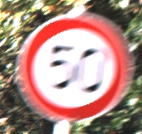

In [ ]:
img

array([[[255, 239, 177],
        [173, 182, 106],
        [140, 175,  98],
        ...,
        [164, 126, 110],
        [246, 160, 140],
        [255, 222, 198]],

       [[239, 223, 157],
        [211, 209, 117],
        [184, 196, 111],
        ...,
        [153, 132, 127],
        [235, 179, 148],
        [231, 189, 131]],

       [[255, 239, 195],
        [248, 235, 168],
        [197, 186, 123],
        ...,
        [135, 131, 127],
        [202, 175, 155],
        [177, 157, 121]],

       ...,

       [[107,  92,  80],
        [103,  95,  76],
        [ 99,  98,  87],
        ...,
        [161, 161, 126],
        [146, 145, 127],
        [156, 147, 145]],

       [[ 96,  74,  63],
        [ 73,  66,  51],
        [ 60,  68,  51],
        ...,
        [234, 228, 199],
        [224, 219, 201],
        [224, 210, 203]],

       [[ 68,  56,  45],
        [ 60,  57,  45],
        [ 41,  47,  23],
        ...,
        [239, 234, 211],
        [220, 214, 196],
        [188, 175, 162]]], dtype=uint8)
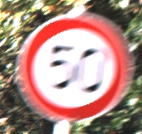

In [ ]:
image

In [ ]:
masks = mask_generator.generate(image)

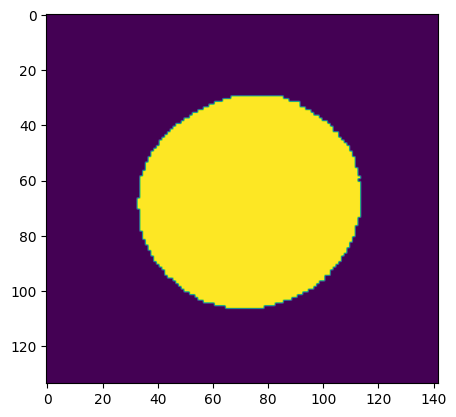

In [ ]:
# This is used to find the mask index. TODO: modify to show a grid of images.

max_index = 1
plt.imshow(masks[max_index]['segmentation'])

In [ ]:
mask = Image.fromarray( masks[max_index]['segmentation'] ).convert("RGB")

In [ ]:
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as maskfile:
    mask.save(maskfile, format='PNG')

In [ ]:
mask = Image.open(maskfile.name)

In [ ]:
attack_type = "physical"

In [ ]:
pre_process = transforms.Compose([
    pre_process_image, transforms.ToTensor()])

particle_size = 10
iter_num = 200
x_min, x_max = -112, 336
max_speed = 10.
n_try = 1

In [ ]:
# TODO: move these to a helper file

def attack(attack_image, label, coords, targeted_attack=False, physical_attack=False, **parameters):
    r"""
    Physical-world adversarial attack by shadow.

    Args:
        attack_image: The image to be attacked.
        label: The ground-truth label of attack_image.
        coords: The coordinates of the points where mask == 1.
        targeted_attack: Targeted / Non-targeted attack.
        physical_attack: Physical / digital attack.

    Returns:
        adv_img: The generated adversarial image.
        succeed: Whether the attack is successful.
        num_query: Number of queries.
    """
    num_query = 0
    succeed = False
    global_best_solution = float('inf')
    global_best_position = None

    for attempt in range(n_try):

        if succeed:
            break

        print(f"try {attempt + 1}:", end=" ")

        pso = PSO(polygon*2, particle_size, iter_num, x_min, x_max, max_speed,
                  shadow_level, attack_image, coords, model, targeted_attack,
                  physical_attack, label, pre_process, **parameters)
        best_solution, best_pos, succeed, query = pso.update_digital() \
            if not physical_attack else pso.update_physical()

        if targeted_attack:
            best_solution = 1 - best_solution
        print(f"Best solution: {best_solution} {'succeed' if succeed else 'failed'}")
        if best_solution < global_best_solution:
            global_best_solution = best_solution
            global_best_position = best_pos
        num_query += query

    adv_image, shadow_area = draw_shadow(
        global_best_position, attack_image, coords, shadow_level)
    adv_image = shadow_edge_blur(adv_image, shadow_area, 3)

    return adv_image, succeed, num_query

def attack_physical(output_file):

    global position_list

    mask_image = cv2.resize(
        cv2.imread(mask_path, cv2.IMREAD_UNCHANGED), (224, 224))
    target_image = cv2.resize(
        cv2.imread(image_path), (224, 224))
    pos_list = np.where(mask_image.sum(axis=2) > 0)

    # EOT is included in the first stage
    adv_img, _, _ = attack(target_image, image_label, pos_list,
                           physical_attack=True, transform_num=10)

    cv2.imwrite('./tmp/temp.bmp', adv_img)
    if attack_db == 'LISA':
        predict, failed = lisa.test_single_image(
            './tmp/temp.bmp', image_label, target_model == "robust")
    else:
        predict, failed = gtsrb.test_single_image(
            './tmp/temp.bmp', image_label, target_model == "robust")
    if failed:
        print('Attack failed! Try to run again.')

    # Predict stabilization
    adv_img, _, _ = attack(target_image, image_label, pos_list, targeted_attack=True,
                           physical_attack=True, target=predict, transform_num=10)

    cv2.imwrite(output_file, adv_img)

In [ ]:
shadow_level = 0.6
target_model = "normal"
attack_db = "GTSRB"
image_path = tmpfile.name
mask_path = maskfile.name
image_label = label
polygon = 4
n_try = 5

In [ ]:
attempt = 0

In [ ]:
output_file = f"/content/{img_index}_{shadow_level}_{attempt}.png"
attack_physical(output_file)
attempt += 1

try 1: iteration: 1 0.07066293060779572
iteration: 2 0.07066293060779572
iteration: 3 0.07066293060779572
iteration: 4 0.008543485775589943
iteration: 5 0.008543485775589943
iteration: 6 0.008543485775589943
iteration: 7 0.008543485775589943
iteration: 8 0.006406216882169247
iteration: 9 0.006406216882169247
iteration: 10 0.006406216882169247
iteration: 11 0.006406216882169247
iteration: 12 0.005953776650130749
iteration: 13 0.005953776650130749
iteration: 14 0.005953776650130749
iteration: 15 0.005953776650130749
iteration: 16 0.005953776650130749
iteration: 17 0.0025736901443451643
iteration: 18 0.0025736901443451643
iteration: 19 0.0025736901443451643
iteration: 20 0.0025736901443451643
iteration: 21 0.0025736901443451643
iteration: 22 0.0025736901443451643
iteration: 23 0.0025736901443451643
iteration: 24 0.0025736901443451643
iteration: 25 0.0025736901443451643
iteration: 26 0.0025736901443451643
iteration: 27 0.0025736901443451643
iteration: 28 0.0025736901443451643
iteration: 29

In [ ]:
## Step 4: Run the model on the adversarially modified image to show that the attack worked

In [ ]:
test_single_image(output_file, label)
print(output_file)

Correct: False Predict: 3 Confidence: 95.61741948127747%
/content/3088_0.6_0.png


In [ ]:
img.save("/content/base.png")

In [ ]:
## Step 5: Generate explaination for the modified prediction

# TODO: Move all of this to a single helper function

In [ ]:
def pre_process_image(image):
    image[:, :, 0] = cv2.equalizeHist(image[:, :, 0])
    image[:, :, 1] = cv2.equalizeHist(image[:, :, 1])
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = image / 255. - .5
    return image.astype(np.float32)

In [ ]:
img_file = output_file

In [ ]:
target_image = cv2.resize(
        cv2.imread(img_file), (224, 224))

pre_process = transforms.Compose([
        pre_process_image, transforms.ToTensor()])

target_image = cv2.resize(
        target_image, (32, 32))

img = pre_process(target_image)

In [ ]:
# ## This is just a code snippet for performing inference
# probs = torch.softmax(model(img.unsqueeze(dim=0).to(device)), 1)

# probs[0].argmax()
# probs[0].max()

In [ ]:
def grad_cam_heatmap(image, model):
    target_layers = [model.module2[-1]] # Good options are model.module2[-1] and model.module3[-1]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = None
    grayscale_cam = cam(input_tensor=image, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    return grayscale_cam

In [ ]:
target_image = cv2.resize(
        cv2.imread(img_file), (224, 224))

In [ ]:
vis = grad_cam_heatmap(img.unsqueeze(dim=0), model)

In [ ]:
x = torch.tensor(vis).unsqueeze(0).unsqueeze(0)
x_interpolated = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False).squeeze()

In [ ]:
orig=torch.tensor(target_image / 255).permute(2, 0, 1)

In [ ]:
# x_interpolated.repeat_interleave(3, dim=0).view(224, 224, 3)

In [ ]:
visualization = show_cam_on_image(
    np.moveaxis(orig.numpy(), 0, -1), x_interpolated, use_rgb=True)

array([[[ 88, 120, 191],
        [ 73, 106, 173],
        [ 53,  90, 148],
        ...,
        [ 68,  79, 183],
        [ 86,  97, 189],
        [ 99, 111, 191]],

       [[ 84, 116, 188],
        [ 71, 108, 174],
        [ 55,  96, 156],
        ...,
        [ 71,  82, 181],
        [ 80,  95, 186],
        [ 85, 104, 186]],

       [[ 78, 111, 183],
        [ 69, 108, 176],
        [ 58, 104, 168],
        ...,
        [ 73,  88, 177],
        [ 69,  92, 180],
        [ 65,  94, 180]],

       ...,

       [[ 31,  37, 112],
        [ 28,  35, 106],
        [ 25,  33, 100],
        ...,
        [117, 238, 223],
        [118, 235, 223],
        [118, 232, 223]],

       [[ 26,  31, 104],
        [ 25,  31, 100],
        [ 23,  30,  96],
        ...,
        [116, 236, 222],
        [111, 228, 216],
        [106, 222, 212]],

       [[ 22,  28,  98],
        [ 22,  28,  95],
        [ 21,  28,  93],
        ...,
        [115, 235, 221],
        [105, 223, 212],
        [ 98, 215, 204]]], dtype=uint8)
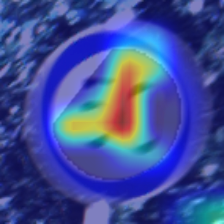

In [ ]:
visualization

In [ ]:
## Now, I'd like to make an even better vocabulary and implement the following psuedo-code:
# 1. load image
# 2. predict image
# 3. attack image
# 4. perdict attacked iamge
# 5. explain image
# 6. explain attached image

# Note: I will likely need to add a helper function for the most manual step of this operation, which is 3 and needs a mask